Bayesian_posterior-based_EnKF

In [1]:
%%writefile  Bayesian_posterior-based_EnKF_field_scale.py
# Note that we use PCSE 5.5.1, new version PCSE can be different
# Reference: https://github.com/ajwdewit/pcse_notebooks
import csv
import copy
import pcse
import glob
import spotpy
import sys, os
import warnings
import rioxarray
import matplotlib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
from shutil import copyfile

from pcse.util import Afgen
from setup_for_field_enkf import spot_setup
from model_runner import ModelData,ModelRunner
from multiprocessing import Pool #导入进程池

warnings.filterwarnings ( 'ignore')
matplotlib.style.use("ggplot")

font_path = 'Share_Data_for_field/Times New Roman.ttf'
enfont=mpl.font_manager.FontProperties(fname=font_path,size=10.5)

config = {
    "font.family":'serif',
    "font.size": 10.5,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'], 
}

def run_enkf(task,fig_show=False,update_em=True,update_ts=True):
    area,year,i_th=task
    ds_PAC=rioxarray.open_rasterio('Share_Data_for_field/Henan_PAC.tif')
    select_pars=['β_IDEM','α_TSUM1','α_TSUM2','α_TDWI', 'α_SPAN', 'α_SLATB', 'α_AMAXTB', 'β_DVS', 'α_v', 'α_CVO']

    spot=spot_setup(select_pars, area, i_th, year,cal_prior=False)
    try:
        observations_for_DA=spot.evaluation(enkf_flg=True)
        # print(pd.DataFrame(observations_for_DA))
    except:
        return None

    lon,lat=spot.lon,spot.lat
    pac=ds_PAC.sel(x=lon,y=lat,method='nearest').data[0]
    
    data=spot.data
    file=glob.glob('Share_Data_for_field/MCMC/DREAM_WOFOST_*_%d_%04d_%04d.csv'%(year-1,data[i_th][0],data[i_th][1]))[0]
    # print(file)
    copyfile(file, file.replace('MCMC','MCMC2'))
    results = spotpy.analyser.load_csv_results(file[:-4])
    pars=[word for word in results.dtype.names if word.startswith('par')]
    ensemble_size = 50
    par_ens=results[pars][-ensemble_size*20::20]

    override_parameters=dict(zip([l[3:] for l in par_ens.dtype.names],np.array([list(l) for l in list(par_ens)]).T))

    # WOFOST parameters
    code=spot.area_grids.Id[spot.i_th]
    TSUM1,TSUM2=spot.area_grids['TSUM1_%d'%year][spot.i_th],spot.area_grids['TSUM2_%d'%year][spot.i_th]

    wdp, params=ModelData(lon,lat,TSUM=[TSUM1,TSUM2])
    model_runner = ModelRunner(code, params, wdp, year,spot.calendar_date,select_pars)
    cvo=1.0
    ensemble = []
    for i in range(ensemble_size):
        em,ts1,ts2=list(par_ens[i])[:3]
        if not update_em:
            em=0
        if not update_ts:
            ts1,ts2=1.0,1.0
        x=[em,ts1,ts2]+list(par_ens[i])[3:]+[cvo]
        if x[3]<0:
            x[3]=0.1 #TDWI
        member = model_runner(x,wofsim_flg=True)
        ensemble.append(member)
    
    observations_for_DA_= copy.deepcopy(observations_for_DA)
    variables_for_DA=['LAI']

    for _ in range(len(observations_for_DA)):
        #Move the ensemble forward in time until the first analysis step
        day, obs = observations_for_DA_.pop(0)
        for member in ensemble:
            member.run_till(day)
        # print("%s observations left!" % len(observations_for_DA_))
        # print(len(observations_for_DA_),end='.')
        
        # Retrieve the states from the ensemble
        collected_states = []
        for member in ensemble:
            t = {}
            for state in variables_for_DA:
                t[state] = member.get_variable(state)
            collected_states.append(t)
        df_A = pd.DataFrame(collected_states)
        A = np.matrix(df_A).T

        # Compute covariance within ensemble states
        P_e = np.matrix(df_A.cov())

        # Calculate perturbed observations and their mean and covariance
        perturbed_obs = []
        for state in variables_for_DA:
            (value, std) = obs[state]
            d = np.random.normal(value, std, (ensemble_size))
            perturbed_obs.append(d)
        df_perturbed_obs = pd.DataFrame(perturbed_obs).T
        df_perturbed_obs.columns = variables_for_DA
        D = np.matrix(df_perturbed_obs).T
        R_e = np.matrix(df_perturbed_obs.cov())

        # Apply the Kalman filter equations
        # Here we compute the Kalman gain
        H = np.identity(len(obs))
        K1 = P_e * (H.T)
        K2 = (H * P_e) * H.T
        K = K1 * ((K2 + R_e).I)

        # Here we compute the analysed states
        Aa = A + K * (D - (H * A))
        df_Aa = pd.DataFrame(Aa.T, columns=variables_for_DA)

        # Update the ensemble to reflect the new state
        for member, new_states in zip(ensemble, df_Aa.itertuples()):
            member.set_variable("LAI", new_states.LAI)
            
    # Run all the ensemble members until the end of the growing season
    for member in ensemble:
        member.run_till_terminate()

    # Retrieve output from the ensemble
    results = []
    d=1
    c2i=8.27/21.
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.5*c2i*2,5*c2i))
    for member in ensemble:
        member_df = pd.DataFrame(member.get_output()).set_index("day")[['LAI','TWSO']]
        results.append(member_df.TWSO.max())

        member_df["LAI"].plot(style="k:", ax=axes[0],lw=0.45)
        member_df["TWSO"].plot(style="k:", ax=axes[1],lw=0.45)    
        d+=1
    axes[0].errorbar(spot.evaluation().index[:-1], spot.evaluation().mu[:-1], yerr=spot.evaluation().sigma[:-1]*2, fmt="o", ms=3, zorder=5)
    axes[1].errorbar(spot.evaluation().index[-1:], spot.evaluation().mu[-1:], yerr=spot.evaluation().sigma[-1:]*1.5, fmt="o", ms=3, zorder=5)
    axes[0].set_title("LAI",fontproperties=enfont)
    axes[1].set_title("TWSO",fontproperties=enfont)
    axes[0].set_xlabel('')
    axes[1].set_xlabel('')
    axes[0].set_xlim(member_df.index[0],spot.evaluation().index[-1]+dt.timedelta(3))
    axes[1].set_xlim(member_df.index[0],spot.evaluation().index[-1]+dt.timedelta(3))

    fig.autofmt_xdate()
    fig.savefig('Share_Data_for_field/fig/%d-%d-%4d_%04d.png'%(year,pac,data[i_th][0],data[i_th][1]),dpi=200,bbox_inches='tight')
    if not fig_show:
        plt.clf()        

    return [pac,i_th,data[i_th][0],data[i_th][1],np.mean(results),np.percentile(results,16),np.percentile(results,84),spot.evaluation().mu[-1]]

def mycallback(x):
    try:
        csv_write.writerow(x)
    except:
        pass

if __name__ == '__main__':      

    data = np.load('Share_Data_for_field/data.npy', allow_pickle=True)
    e1 = dt.datetime.now() 
    year=2021
    file='Share_Data_for_field/Henan_%d.csv'%year   
    csv_file = open(file, 'w')
    csv_write = csv.writer(csv_file)
    p = Pool(len(data))
    
    tasks=[]
    for i_th in range(len(data)):        
        tasks.append(['Henan',year,int(i_th)])
    for task in tasks:
        p.apply_async(func=run_enkf, args=(task,),callback=mycallback)
    p.close()
    p.join()

    csv_file.close()
    e2 = dt.datetime.now()
    print(e2-e1)    

Overwriting Bayesian_posterior-based_EnKF_field_scale.py


Run

In [2]:
#Results may vary slightly over multiple runs
# !python Bayesian_posterior-based_EnKF_field_scale.py

Plot

In [3]:
import warnings
import numpy as np
import pandas as pd
import matplotlib as mpl
from scipy import optimize
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
mpl.style.use("ggplot")
warnings.filterwarnings("ignore")

mpl.style.use("ggplot")
warnings.filterwarnings("ignore")

font_path = 'Share_Data_for_field/Times New Roman.ttf'
enfont=mpl.font_manager.FontProperties(fname=font_path,size=10.5)

config = {
    "font.family":'serif',
    "font.size": 10.5,
    "mathtext.fontset":'stix',
    "font.serif": ['Times New Roman'], 
}

rcParams.update(config)
plt.rc('axes', unicode_minus=False)  

def f_1(x, A, B):
    return A * x + B

def Linear_fit(x0,y0):
    A1, B1 = optimize.curve_fit(f_1, x0, y0)[0]
    predictions=[A1*x+B1 for x in x0]
    r2=r2_score(y0,predictions)
    return r2,A1,B1,predictions


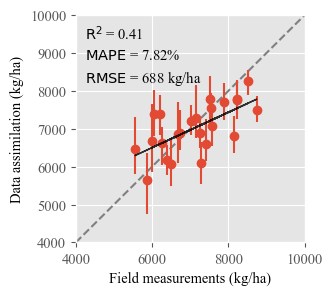

In [4]:
############################# scatter plot #############################
area,year='Henan',2021
data=pd.read_csv('Share_Data_for_field/Henan_2021.csv',header=None)
data.columns=['PAC','num','2020','2021','sim','sim16','sim84','obs']
y, y_hat=np.array(data['obs'].to_list()),np.array(data['sim'].to_list())
# low, high=np.array(data['sim16'].to_list()),np.array(data['sim84'].to_list())
y_error=pd.DataFrame([data['sim']-data['sim16'],data['sim84']-data['sim']]).to_numpy()

vmin,vmax=4000,10000
c2i=8.27/21.
fig= plt.figure(figsize=(7.5*c2i,7.5*c2i))
ax= fig.add_subplot(1,1,1)
# ax.scatter(y,y_hat,zorder=3)
ax.errorbar(y,y_hat,yerr=y_error,fmt='o',zorder=3)
ax.plot([0,100000],[0,100000],c='gray',ls='--')
ax.set_xlim(vmin,vmax)
ax.set_ylim(vmin,vmax)
ax.set_xlabel('Field measurements (kg/ha)', fontproperties=enfont,c='k')
ax.set_ylabel('Data assimilation (kg/ha)', fontproperties=enfont,c='k')


r2,A1,B1,predictions=Linear_fit(y,y_hat)
# r2=r2_score(y, y_hat)
ax.plot(y,predictions,ms=0,ls='-', lw=1, c='k',alpha=0.8,zorder=5)
RMSE = np.sqrt(np.mean(np.square(y - y_hat)))
MAE = np.mean(np.abs(y-y_hat))
MAPE = np.mean(np.abs((y - y_hat) / y)) * 100
plt.text(0.04,0.92,'$\mathrm{R}^{2}$ = %.2f'%(round(r2*100)/100),horizontalalignment='left',verticalalignment='center',transform=ax.transAxes, fontproperties=enfont)
plt.text(0.04,0.82,'$\mathrm{MAPE}$ = %.2f%%'%(MAPE),horizontalalignment='left',verticalalignment='center',transform=ax.transAxes, fontproperties=enfont)
plt.text(0.04,0.72,'$\mathrm{RMSE}$ = %d kg/ha'%(round(RMSE)),horizontalalignment='left',verticalalignment='center',transform=ax.transAxes, fontproperties=enfont)
fig.savefig('Share_Data_for_field/fig/Field_validation_%s_%d_en.png'%(area,year),dpi=300,bbox_inches='tight')
